<a href="https://colab.research.google.com/github/YEONGHUN-H/Healthcare_project/blob/main/%EB%B6%80%EC%A0%95%EB%A7%A5%EC%98%88%EC%B8%A1_%EC%8B%A4%ED%97%98%EA%B3%BC%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.9 MB/s eta 0:00:00


# 데이터 가공하기.
파일 압축 해제



In [ ]:
import zipfile
import os

# 압축 파일 경로
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-bih-arrhythmia-database-1.0.0.zip'

# 압축 해제 경로
extracted_folder_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-database'

# 압축 파일 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

print(f"압축 해제 완료. 데이터는 {extracted_folder_path}에 저장되었습니다.")


압축 해제 완료. 데이터는 /content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-database에 저장되었습니다.


#불필요한 파일 삭제

In [ ]:
import os

# 압축 해제된 폴더 경로
extracted_folder_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-database/mit-bih-arrhythmia-database-1.0.0'

# 필요한 확장자
required_extensions = ['.dat', '.hea', '.atr']

# 불필요 파일 삭제
for root, dirs, files in os.walk(extracted_folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        if not any(file.endswith(ext) for ext in required_extensions):
            print(f"삭제 중: {file_path}")
            os.remove(file_path)  # 파일 삭제


# 데이터 탐색
어떤 파일 있는지 탐색

In [ ]:
# 파일 목록 출력
for root, dirs, files in os.walk(extracted_folder_path):
    for file in files:
        print(os.path.join(root, file))


/content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-database/mit-bih-arrhythmia-database-1.0.0/100.atr
/content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-database/mit-bih-arrhythmia-database-1.0.0/100.dat
/content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-database/mit-bih-arrhythmia-database-1.0.0/100.hea
/content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-database/mit-bih-arrhythmia-database-1.0.0/101.atr
/content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-database/mit-bih-arrhythmia-database-1.0.0/101.dat
/content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-database/mit-bih-arrhythmia-database-1.0.0/101.hea
/content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-database/mit-bih-arrhythmia-database-1.0.0/102-0.atr
/content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-database/mit-bih-arrhythmia-database-1.0.0/102.atr
/content/drive

# 정상/비정상 데이터 분리

symbol 값이 **'N'**이면 normal_data 리스트에 추가 → 정상 데이터.

나머지 symbol 값들은 모두 abnormal_data 리스트에 추가 → 비정상 데이터.
데이터 만들 때 샘플 주변의 원시 신호 데이터를 포함한 형태로 저장

주요 수정 사항

원시 신호 추출:어노테이션(Sample) 주변의 일정 구간(예: ±5초)의 원시 신호 데이터를 .dat 파일에서 가져옵니다.
wfdb.rdsamp()을 사용하여 원시 신호를 읽어옵니다.

데이터 구조 변경: 기존의 Record, Sample, Type 외에, 해당 샘플 주변의 원시 신호 데이터를 추가합니다.
원시 신호는 하나의 리스트 또는 배열로 저장.

CSV 파일에 저장하기 적합한 형식으로 변경:원시 신호 데이터를 컬럼에 추가하거나, 별도의 파일로 저장합니다.

In [ ]:
import wfdb
import os
import pandas as pd

# 데이터 폴더 경로
data_folder = '/content/drive/MyDrive/Colab Notebooks/기계학습프로그램/부정맥/mit-database/mit-bih-arrhythmia-database-1.0.0'

# 원시 신호 추출 범위 (예: ±5초)
sample_rate = 360  # 일반적인 MIT-BIH 샘플 속도 (헤더 파일에서 확인 가능)
window_size = 5 * sample_rate  # ±5초

# 결과 저장
normal_data = []
abnormal_data = []

# 레코드별 데이터 처리
records = [f.split('.')[0] for f in os.listdir(data_folder) if f.endswith('.dat')]

for record in records:
    record_path = os.path.join(data_folder, record)

    # 원시 신호 읽기
    signals, fields = wfdb.rdsamp(record_path)  # .dat에서 원시 신호 추출
    annotation = wfdb.rdann(record_path, 'atr')  # 어노테이션 읽기

    # 각 어노테이션 처리
    for sample, symbol in zip(annotation.sample, annotation.symbol):
        # 신호 추출 범위 설정
        start_idx = max(0, sample - window_size // 2)
        end_idx = min(len(signals), sample + window_size // 2)
        signal_segment = signals[start_idx:end_idx, 0]  # 첫 번째 채널 신호만 사용 (다채널일 경우 확장 가능)

        # 데이터 저장
        if symbol == 'N':  # 정상 리듬
            normal_data.append({
                'Record': record,
                'Sample': sample,
                'Type': 'NORMAL',
                'Signal': list(signal_segment)  # 신호 데이터를 리스트로 저장
            })
        else:  # 비정상 리듬
            abnormal_data.append({
                'Record': record,
                'Sample': sample,
                'Type': symbol,
                'Signal': list(signal_segment)
            })

# 데이터프레임으로 변환
normal_df = pd.DataFrame(normal_data)
abnormal_df = pd.DataFrame(abnormal_data)

# CSV로 저장 (신호 데이터는 별도의 파일로 저장하거나 JSON 포맷 추천)
normal_df.to_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/normal_signals.csv', index=False)
abnormal_df.to_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/abnormal_signals.csv', index=False)

print("정상 및 비정상 데이터 CSV로 저장 완료.")



정상 및 비정상 데이터 CSV로 저장 완료.


#동작원리
데이터 폴더 경로에서 레코드 추출:

폴더 내 .dat 파일 목록을 읽고, 각 레코드 이름을 추출합니다.
.dat 파일과 동일한 이름을 가진 .atr 파일을 기준으로 어노테이션 데이터를 가져옵니다.
wfdb.rdann 함수로 어노테이션 읽기:

.atr 파일에는 각 심전도 기록에 대한 어노테이션(리듬/이벤트 정보)이 포함되어 있습니다.
rdann 함수는 샘플 위치(sample)와 심전도 태그(symbol)을 반환합니다.
심전도 리듬 분류:

반복문에서 각 어노테이션의 symbol 값을 확인합니다.
symbol == 'N': 정상 리듬으로 간주하여 normal_data 리스트에 추가합니다.
나머지 symbol 값: 비정상 리듬으로 간주하여 abnormal_data 리스트에 추가합니다.
결과를 리스트에 저장:

각각의 레코드 이름, 샘플 위치(sample), 리듬 타입(NORMAL 또는 비정상 태그)을 저장합니다.
데이터프레임 변환 및 CSV 저장:

정상 리듬(normal_data)과 비정상 리듬(abnormal_data) 데이터를 별도의 pandas.DataFrame으로 변환합니다.
이를 CSV 파일로 저장합니다.
어노테이션의 symbol 태그
MIT-BIH 데이터셋에서 symbol 태그는 다음과 같은 심장 리듬 또는 이벤트를 나타냅니다:

'N': 정상 리듬
'V': 심실 기외수축(Ventricular ectopic beat)
'A': 심방 조기수축(Atrial premature contraction)
'L': 좌심실 조기수축(Left bundle branch block beat)
기타 다양한 비정상 태그.

# 정상 비정상 데이터 합침

In [ ]:
import pandas as pd
import numpy as np
import os

# 데이터 경로 설정
abnormal_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/abnormal_signals.csv'
normal_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/normal_signals.csv'

# 데이터 읽기
abnormal_data = pd.read_csv(abnormal_path)
normal_data = pd.read_csv(normal_path)

# 신호 데이터를 리스트에서 배열로 변환
abnormal_data['Signal'] = abnormal_data['Signal'].apply(lambda x: np.array(eval(x)))
normal_data['Signal'] = normal_data['Signal'].apply(lambda x: np.array(eval(x)))

# 고정 크기 설정
fixed_length = 512

def pad_or_trim(signal, target_length=fixed_length):
    """신호 데이터를 고정된 길이로 패딩 또는 잘라내기"""
    if len(signal) < target_length:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')
    elif len(signal) > target_length:
        return signal[:target_length]
    else:
        return signal

# 신호 크기 조정
abnormal_data['Signal'] = abnormal_data['Signal'].apply(pad_or_trim)
normal_data['Signal'] = normal_data['Signal'].apply(pad_or_trim)

# 동일한 크기로 샘플링
min_samples = min(len(abnormal_data), len(normal_data))
abnormal_sampled = abnormal_data.sample(n=min_samples, random_state=42)
normal_sampled = normal_data.sample(n=min_samples, random_state=42)

# 데이터 병합
combined_data = pd.concat([abnormal_sampled, normal_sampled], ignore_index=True)

# 데이터 세그먼트화
segment_size = 512
segments = []
labels = []

for i in range(0, len(combined_data), segment_size):
    segment = combined_data.iloc[i:i + segment_size]
    signals = np.stack(segment['Signal'].values)  # 고정 크기 배열 병합
    label = 1.0 if (segment['Type'] != 'NORMAL').sum() > (segment['Type'] == 'NORMAL').sum() else 0.0

    if signals.shape[0] < segment_size:
        print(f"Skipping segment starting at index {i} due to insufficient size.")
        continue

    # 통계값 계산 (평균, 중앙값, RMS, 표준편차)
    mean_values = np.mean(signals, axis=0)
    median_values = np.median(signals, axis=0)
    rms_values = np.sqrt(np.mean(np.square(signals), axis=0))
    std_values = np.std(signals, axis=0)

    # 통계값을 결합하여 특징 벡터 생성
    stats = np.concatenate([mean_values, median_values, rms_values, std_values])
    segments.append(stats)
    labels.append(label)

# 처리된 데이터를 데이터프레임으로 변환
processed_data = pd.DataFrame(segments)
processed_data['Label'] = labels

# 저장 경로 확인
output_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/processed_data.csv'
assert os.path.exists(os.path.dirname(output_path)), "Output directory does not exist."

# CSV 저장
processed_data.to_csv(output_path, index=False)
print("Data processing complete. Processed data saved to:", output_path)

# 병합된 데이터에서 클래스 분포 확인
print("Combined data class distribution:")
print(combined_data['Type'].value_counts())


Skipping segment starting at index 74752 due to insufficient size.
Data processing complete. Processed data saved to: /content/drive/MyDrive/Colab Notebooks/기계학습프로그램/기말데이터/processed_data.csv
Combined data class distribution:
Type
NORMAL    37595
L          8075
R          7259
V          7130
/          7028
A          2546
+          1291
f           982
F           803
~           616
!           472
"           437
j           229
x           193
a           150
|           132
E           106
J            83
Q            33
e            16
]             6
[             6
S             2
Name: count, dtype: int64


#테스트/훈련으로 나누기.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 데이터 로드
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/processed_data.csv')

# 특징 데이터(X)와 라벨(y) 분리
X = data.drop(columns=['Label'])  # 특징 데이터
y = data['Label']  # 라벨

# 학습/테스트 데이터 분리 (80:20 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 훈련 데이터와 테스트 데이터를 병합하여 저장
train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

# CSV로 저장
train_data.to_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train2_data.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test2_data.csv', index=False)

print("Train data saved to: 지정한 훈련 경로")
print("Test data saved to: 지정한 테스트 경로")

print("Original data class distribution:")
print(y.value_counts())

print("Train data class distribution:")
print(y_train.value_counts())

print("Test data class distribution:")
print(y_test.value_counts())

Train data saved to: 지정한 훈련 경로
Test data saved to: 지정한 테스트 경로
Original data class distribution:
Label
1.0    73
0.0    73
Name: count, dtype: int64
Train data class distribution:
Label
1.0    58
0.0    58
Name: count, dtype: int64
Test data class distribution:
Label
0.0    15
1.0    15
Name: count, dtype: int64


# 모델 돌려보기

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 284ms/step - accuracy: 0.5469 - loss: 0.8146 - val_accuracy: 0.2885 - val_loss: nan - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5312 - loss: 0.8639 - val_accuracy: 0.2885 - val_loss: nan - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5904 - loss: 0.8178 - val_accuracy: 0.2500 - val_loss: nan - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5501 - loss: 0.8007 - val_accuracy: 0.3077 - val_loss: nan - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6385 - loss: 0.7003 - val_accuracy: 0.3077 - val_loss: nan - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5885 - loss: 0.7542 - val_accuracy: 0.3077 - val_loss: nan - learning_rate: 5.0000e-04
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5521 - loss: 0.7564 - val_accuracy

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_14 (Flatten)                 │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 512)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,389 (2.02 MB)

 Trainable params: 175,617 (686.00 KB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 351,236 (1.34 MB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2444 - loss: nan 


Test accuracy: 0.2884615361690521
Maximum Validation Accuracy: 32.69%
NaN values found in test_labels
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Confusion Matrix:
 [[31  6]
 [13  2]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.84      0.77        37
         1.0       0.25      0.13      0.17        15

    accuracy                           0.63        52
   macro avg       0.48      0.49      0.47        52
weighted avg       0.57      0.63      0.59        52



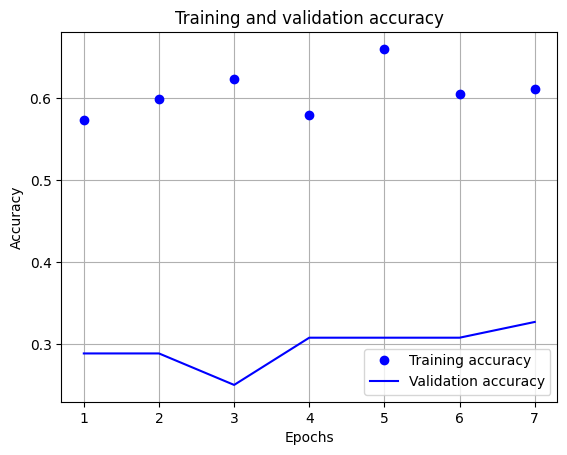

In [ ]:
import pandas as pd
import numpy as np
import keras
from keras import models, layers
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from keras.initializers import HeNormal

# 랜덤 시드 설정
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# CSV 파일 로드
traindata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train2_data.csv')
testdata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test2_data.csv')

# 데이터 정리: 숫자 데이터만 추출
train_images = traindata.select_dtypes(include=[np.number]).iloc[:, :-1].values
train_labels = traindata.iloc[:, -1].values
test_images = testdata.select_dtypes(include=[np.number]).iloc[:, :-1].values
test_labels = testdata.iloc[:, -1].values

# 중앙값 계산 및 NaN 대체
train_images = np.where(np.isnan(train_images), np.nanmedian(train_images, axis=0), train_images)
test_images = np.where(np.isnan(test_images), np.nanmedian(test_images, axis=0), test_images)

# 데이터 표준화 (Standardization)
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

# PCA로 차원 축소
pca = PCA(n_components=2)  # 상위 2개의 주요 구성 요소만 사용
train_features = pca.fit_transform(train_images)
test_features = pca.transform(test_images)

# Ensure no NaN values in train_labels
train_labels = np.nan_to_num(train_labels)  # Convert NaNs to 0

# SMOTE로 데이터 증강
smote = SMOTE(random_state=42)
train_features_balanced, train_labels_balanced = smote.fit_resample(train_features, train_labels)

# Ensure no NaN values in train_features_balanced and train_labels_balanced
assert not np.any(np.isnan(train_features_balanced)), "NaN values in train_features_balanced"
assert not np.any(np.isnan(train_labels_balanced)), "NaN values in train_labels_balanced"

# MLP 신경망 모델 구성
network = models.Sequential()
network.add(layers.Flatten(input_shape=(train_features_balanced.shape[1],)))

network.add(layers.Dense(512, activation='relu', kernel_initializer=HeNormal()))
network.add(layers.BatchNormalization())
network.add(layers.Dense(256, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dropout(0.4))  # Dropout 비율 증가
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dropout(0.4))

network.add(layers.Dense(1, activation='sigmoid'))

# 최적화 및 손실 함수 설정
optimizer = Adam(learning_rate=0.001)
network.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 학습 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# 모델 학습
history = network.fit(
    train_features_balanced, train_labels_balanced,
    batch_size=16,  # 배치 크기 증가
    epochs=100,  # 최대 에포크 수 증가
    validation_data=(test_features, test_labels),
    callbacks=[reduce_lr, early_stopping]
)

# 모델 구조 출력
network.summary()

# 테스트 데이터 평가
test_loss, test_acc = network.evaluate(test_features, test_labels)
print('Test accuracy:', test_acc)

# 최고 검증 정확도 출력
max_val_acc = max(history.history['val_accuracy'])
print(f'Maximum Validation Accuracy: {max_val_acc * 100:.2f}%')

# NaN 값이 있는지 확인하고 제거 (test_labels)
if np.any(np.isnan(test_labels)):
    print("NaN values found in test_labels")
    test_labels = np.nan_to_num(test_labels)  # NaN을 0으로 대체

# 혼동 행렬 및 분류 리포트 출력
predictions = network.predict(test_features)
predictions = (predictions > 0.5)  # 시그모이드 출력값을 0.5 기준으로 이진 분류

print("Confusion Matrix:\n", confusion_matrix(test_labels, predictions))
print("Classification Report:\n", classification_report(test_labels, predictions))

# 학습 및 검증 정확도 그래프 출력
epochs = range(1, len(history.history['accuracy']) + 1)

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



# 수정된 방식으로 데이터 가공 방식을 변경해서 진행해봄

<수정 내용>
샘플링 시점: 데이터를 합치기 전에 개별적으로 정상/비정상 데이터를 샘플링합니다.
라벨링 방식:정상 데이터는 라벨 0, 비정상 데이터는 라벨 1로 유지합니다.
데이터 나누는 방식:정상/비정상 데이터를 합친 후 섞지 않고, 개별적으로 Train/Test 데이터를 나눈 후 각각 합칩니다.

#데이터의 크기가 달라도 상관없는가?
<독립적인 샘플링>
정상과 비정상을 개별적으로 샘플링하기에 상관없다.
각각의 train_ratio 비율로 train/test 나누기 때문에 두 데이터의 크기가 달라도 동일한 비율로 나뉜다.
<클래스 불균형 처리>
정상과 비정상 데이터의 크기가 다르면 클래스 샘플 수가 달라서 문제가 있을 수 있으나 라벨을 기준으로 분포를 확인하고 클래스간 균형을 맞추는 방법을 사용한다면 괜찮아짐
<클래스 불균형 대응>
언더샘플링으로 더 작은 클래스를 기준으로 맞추게함

<현재 코드>
이 코드에서는 클래스간 균형을 맞추지는 않았으나 데이터의 원래 분포를 그대로 유지시킴




#개선방안

이 코드가 작동한다면
고정 크기 설정(fixed_length) 수정해보기
fixed_length = 512은 신호 데이터를 512개의 값으로 고정한다는 뜻입니다. 신호 데이터가 원래 길이가 짧거나 길더라도, 고정된 길이로 맞춰주는 과정.
이 과정에서 1000으로 설정해서 정밀한 검사와 진행해서 비교해보기.

In [ ]:
import pandas as pd
import numpy as np
import os

# 데이터 경로 설정
abnormal_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/abnormal_signals.csv'
normal_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/normal_signals.csv'

# 데이터 읽기
abnormal_data = pd.read_csv(abnormal_path)
normal_data = pd.read_csv(normal_path)

# 신호 데이터를 리스트에서 배열로 변환
abnormal_data['Signal'] = abnormal_data['Signal'].apply(lambda x: np.array(eval(x)))
normal_data['Signal'] = normal_data['Signal'].apply(lambda x: np.array(eval(x)))

# 고정 크기 설정
fixed_length = 512

def pad_or_trim(signal, target_length=fixed_length):
    """신호 데이터를 고정된 길이로 패딩 또는 잘라내기"""
    if len(signal) < target_length:
        return np.pad(signal, (0, target_length - len(signal)), 'constant')
    elif len(signal) > target_length:
        return signal[:target_length]
    else:
        return signal

# 신호 크기 조정
abnormal_data['Signal'] = abnormal_data['Signal'].apply(pad_or_trim)
normal_data['Signal'] = normal_data['Signal'].apply(pad_or_trim)

# 데이터 라벨링
abnormal_data['Label'] = 1  # 비정상 라벨
normal_data['Label'] = 0  # 정상 라벨

# 원하는 Train/Test 데이터 크기 설정
train_size_per_class = 500  # 클래스별 Train 데이터 크기
test_size_per_class = 300   # 클래스별 Test 데이터 크기

# 비정상 데이터 샘플링
abnormal_train = abnormal_data.sample(n=train_size_per_class, random_state=42)
abnormal_test = abnormal_data.drop(abnormal_train.index).sample(n=test_size_per_class, random_state=42)

# 정상 데이터 샘플링
normal_train = normal_data.sample(n=train_size_per_class, random_state=42)
normal_test = normal_data.drop(normal_train.index).sample(n=test_size_per_class, random_state=42)

# Train/Test 데이터 병합
train_data = pd.concat([abnormal_train, normal_train], ignore_index=True)
test_data = pd.concat([abnormal_test, normal_test], ignore_index=True)

# 데이터 섞기
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

# CSV로 저장
output_train_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/ttrain_data.csv'
output_test_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/ttest_data.csv'

assert os.path.exists(os.path.dirname(output_train_path)), "Output directory does not exist."
assert os.path.exists(os.path.dirname(output_test_path)), "Output directory does not exist."

train_data.to_csv(output_train_path, index=False)
test_data.to_csv(output_test_path, index=False)

print("Data processing complete.")
print(f"Train data saved to: {output_train_path}")
print(f"Test data saved to: {output_test_path}")

# 클래스 분포 확인
print("Train data class distribution:")
print(train_data['Label'].value_counts())
print("Test data class distribution:")
print(test_data['Label'].value_counts())



Exception ignored in: <function _xla_gc_callback at 0x7abfddcd9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7abfddcd9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7abfddcd9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x7abfddcd9c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_

# 훈련/테스트 파일 결과

Train 데이터:
클래스 0 (정상): 500개
클래스 1 (비정상): 500개


Test 데이터:
클래스 0 (정상): 300개
클래스 1 (비정상): 300개


#학습 방식

1. 1차원 데이터로 학습
데이터 변환 없이, 고정된 길이(예: 512)의 신호 데이터를 그대로 사용하여 1D 모델에 학습시킬 수 있습니다.
1D CNN 또는 **RNN(LSTM, GRU)**을 사용하여 신호 데이터를 처리하는 방식이 일반적입니다.

2. 이미지화하여 학습
신호 데이터를 이미지로 변환하면 2D 데이터(예: 시계열 신호의 시각화)를 학습할 수 있습니다.
일반적으로 사용하는 방식:
시계열 플롯: 신호 데이터를 그래프로 시각화하여 이미지로 저장.
스펙트로그램: 시계열 신호의 주파수 성분을 분석하여 2D 이미지를 생성.
리사쥬 곡선(Lissajous Curve): 신호 데이터를 X, Y 좌표로 변환하여 그래프 이미지 생성.
이렇게 변환된 이미지는 CNN(Convolutional Neural Network) 같은 모델로 학습할 수 있습니다.

# 1차원 데이터를 사용.




MLP모델을 사용했다.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5395 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5041 - loss: 0.6930 - val_accuracy: 0.4867 - val_loss: 0.6931
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4753 - loss: 0.6930 - val_accuracy: 0.4917 - val_loss: 0.6931
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4973 - loss: 0.6947 - val_accuracy: 0.5067 - val_loss: 0.6930
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4966 - loss: 0.6932 - val_accuracy: 0.5083 - val_loss: 0.6931
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4754 - loss: 0.6934 - val_accuracy: 0.5067 - val_loss: 0.6930
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4875 - loss: 0.6934 - val_accuracy: 0.4967 - val_loss: 0.6930
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5137 - loss: 0.6917 - val_accuracy: 0.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,917 (27.02 KB)

 Trainable params: 2,305 (9.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,612 (18.02 KB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4902 - loss: 0.6932  
Test accuracy: 0.5016666650772095
Maximum Validation Accuracy: 53.17%
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix:
 [[153 147]
 [152 148]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.51       300
           1       0.50      0.49      0.50       300

    accuracy                           0.50       600
   macro avg       0.50      0.50      0.50       600
weighted avg       0.50      0.50      0.50       600



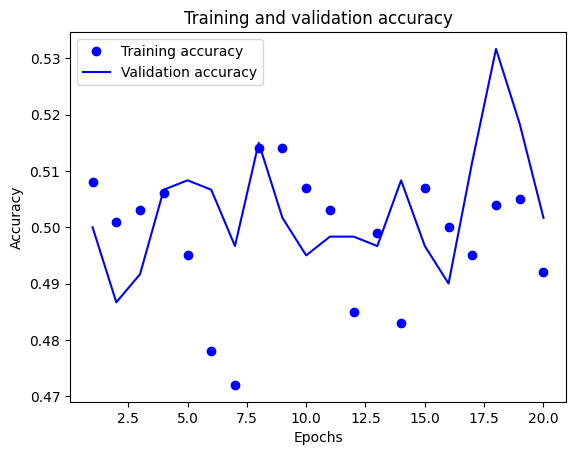

In [ ]:
import pandas as pd
import numpy as np
import keras
from keras import models, layers
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random
import tensorflow as tf

# 랜덤 시드 설정
random.seed(42)                # Python의 random 모듈 시드 설정
np.random.seed(42)             # NumPy 시드 설정
tf.random.set_seed(42)         # TensorFlow(Keras) 시드 설정

# CSV 파일 로드
traindata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data.csv')

# 데이터 정리: 숫자 데이터만 추출
train_images = traindata.select_dtypes(include=[np.number]).iloc[:, :-1].values  # 마지막 열 제외
train_labels = traindata.iloc[:, -1].values  # 마지막 열 (레이블)

testdata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data.csv')
test_images = testdata.select_dtypes(include=[np.number]).iloc[:, :-1].values  # 마지막 열 제외
test_labels = testdata.iloc[:, -1].values  # 마지막 열 (레이블)

# NaN 값 대체
train_images = np.nan_to_num(train_images)
test_images = np.nan_to_num(test_images)

# 데이터 정규화 (Min-Max Scaling)
train_images = (train_images - np.min(train_images)) / (np.max(train_images) - np.min(train_images))
test_images = (test_images - np.min(test_images)) / (np.max(test_images) - np.min(test_images))

# MLP 신경망 모델 구성
network = models.Sequential()

# 입력 데이터를 Flatten하여 1D 데이터로 변환
network.add(layers.Flatten(input_shape=(train_images.shape[1],)))

# Fully Connected Layer
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(32, activation='relu'))

# 드롭아웃: 과적합 방지
network.add(layers.Dropout(0.5))

# 마지막 출력층: 이진 분류를 위한 시그모이드 활성화 함수
network.add(layers.Dense(1, activation='sigmoid'))

# 최적화 및 손실 함수 설정
optimizer = Adam(learning_rate=0.0001)
network.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = network.fit(
    train_images, train_labels,
    batch_size=8,
    epochs=20,
    verbose=1,
    validation_data=(test_images, test_labels)
)

# 모델 구조 출력
network.summary()

# 테스트 데이터 평가
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

# 최고 검증 정확도 출력
max_val_acc = max(history.history['val_accuracy'])
print(f'Maximum Validation Accuracy: {max_val_acc * 100:.2f}%')

# 혼동 행렬 및 분류 리포트 출력
predictions = network.predict(test_images)
predictions = (predictions > 0.5)  # 시그모이드 출력값을 0.5 기준으로 이진 분류

print("Confusion Matrix:\n", confusion_matrix(test_labels, predictions))
print("Classification Report:\n", classification_report(test_labels, predictions))

# 학습 및 검증 정확도 그래프 출력
epochs = range(1, len(history.history['accuracy']) + 1)

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




In [ ]:
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)


Train images shape: (1000, 2, 1)
Test images shape: (600, 2, 1)


In [ ]:
print("Train images:")
print(train_images)
print("Test images:")
print(test_images)


Train images:
[[[2.15504635e-05]
  [4.78095493e-01]]

 [[4.61795646e-06]
  [4.02340996e-01]]

 [[1.58549839e-04]
  [9.81537410e-01]]

 ...

 [[7.69659410e-06]
  [8.97518310e-01]]

 [[1.07752317e-05]
  [7.13888350e-01]]

 [[1.75482346e-04]
  [8.00100979e-01]]]
Test images:
[[[2.77960082e-05]
  [6.51445778e-02]]

 [[1.54422268e-04]
  [4.22843686e-01]]

 [[1.54422268e-04]
  [5.02663012e-01]]

 ...

 [[6.17689071e-06]
  [8.63490715e-01]]

 [[3.39728989e-05]
  [1.75289349e-01]]

 [[1.86850944e-04]
  [4.15848357e-01]]]


#ECG 데이터에 통계적 특징 추가가 유용한 경우
# 위에 코드는 문제가 많음 통계적 특징이 필요함
비정상적인 리듬 탐지:
비정상적인 심장 박동은 특정 통계값(예: 평균, 최대값)의 이상으로 나타날 수 있음.
예를 들어, 심박수 증가/감소는 평균값 변화로 반영될 수 있음.

신호 간 비교가 중요할 때:
다양한 신호 사이에서 통계적 차이를 이용하여 분류를 돕는 경우 유리.

모델이 복잡하지 않을 때:
단순한 MLP(다층 퍼셉트론)나 shallow CNN에서는 이러한 통계적 특징이 분류를 보조할 수 있음.
복잡한 모델에서는 신호 자체에서 특징을 학습할 가능성이 높아 상대적으로 덜 중요.

----------------------------------------------
제안할 추가적인 특징
기울기 및 변화율:
신호의 1차 미분 값(변화율) 및 평균 기울기.
갑작스러운 상승/하강 패턴이 비정상 심박을 나타낼 수 있음.

에너지(에너지원):
Energy=∑(x2): 신호의 전체 에너지.
신호의 강도와 변화를 통합적으로 측정.

피크 탐지 및 개수:
R-파형(피크)의 개수나 분포: 정상 리듬과 비정상 리듬의 주기 차이를 학습 가능.

신호의 스펙트럼 에너지:
특정 주파수 대역에서의 에너지 합산.
FFT(빠른 푸리에 변환)를 사용해 주파수 특성을 반영.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.4795 - loss: 0.9777 - val_accuracy: 0.4950 - val_loss: 0.7509 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4917 - loss: 0.7818 - val_accuracy: 0.5183 - val_loss: 0.7286 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5009 - loss: 0.7557 - val_accuracy: 0.5167 - val_loss: 0.7040 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5342 - loss: 0.7284 - val_accuracy: 0.5383 - val_loss: 0.6911 - learning_rate: 0.0010
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5240 - loss: 0.7149 - val_accuracy: 0.5133 - val_loss: 0.6974 - learning_rate: 0.0010
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5724 - loss: 0.7090 - val_accuracy: 0.5183 - val_loss: 0.6953 - learning_rate: 0.0010
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4960 - loss: 0.7187 - v

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)                 │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 512)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,389 (2.02 MB)

 Trainable params: 175,617 (686.00 KB)

 Non-trainable params: 1,536 (6.00 KB)

 Optimizer params: 351,236 (1.34 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5034 - loss: 0.6953
Test accuracy: 0.5383333563804626
Maximum Validation Accuracy: 53.83%
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Confusion Matrix:
 [[ 95 205]
 [ 72 228]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.32      0.41       300
           1       0.53      0.76      0.62       300

    accuracy                           0.54       600
   macro avg       0.55      0.54      0.51       600
weighted avg       0.55      0.54      0.51       600



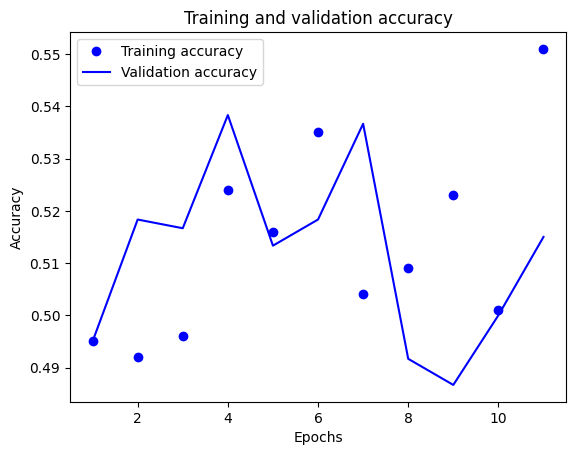

In [ ]:
import pandas as pd
import numpy as np
import keras
from keras import models, layers
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from keras.initializers import HeNormal

# 랜덤 시드 설정
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# CSV 파일 로드
traindata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/ptrain_data.csv')
testdata = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/ptest_data.csv')

# 데이터 정리: 숫자 데이터만 추출
train_images = traindata.select_dtypes(include=[np.number]).iloc[:, :-1].values
train_labels = traindata.iloc[:, -1].values
test_images = testdata.select_dtypes(include=[np.number]).iloc[:, :-1].values
test_labels = testdata.iloc[:, -1].values

# 중앙값 계산 및 NaN 대체
train_images = np.where(np.isnan(train_images), np.nanmedian(train_images, axis=0), train_images)
test_images = np.where(np.isnan(test_images), np.nanmedian(test_images, axis=0), test_images)

# 데이터 표준화 (Standardization)
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

# PCA로 차원 축소
pca = PCA(n_components=2)  # 상위 5개의 주요 구성 요소만 사용
train_features = pca.fit_transform(train_images)
test_features = pca.transform(test_images)

# SMOTE로 데이터 증강
smote = SMOTE(random_state=42)
train_features_balanced, train_labels_balanced = smote.fit_resample(train_features, train_labels)

# MLP 신경망 모델 구성
network = models.Sequential()
network.add(layers.Flatten(input_shape=(train_features_balanced.shape[1],)))

network.add(layers.Dense(512, activation='relu', kernel_initializer=HeNormal()))
network.add(layers.BatchNormalization())
network.add(layers.Dense(256, activation='relu'))
network.add(layers.BatchNormalization())
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dropout(0.4))  # Dropout 비율 증가
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dropout(0.4))

network.add(layers.Dense(1, activation='sigmoid'))

# 최적화 및 손실 함수 설정
optimizer = Adam(learning_rate=0.001)
network.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 학습 콜백 설정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# 모델 학습
history = network.fit(
    train_features_balanced, train_labels_balanced,
    batch_size=16,  # 배치 크기 증가
    epochs=100,  # 최대 에포크 수 증가
    validation_data=(test_features, test_labels),
    callbacks=[reduce_lr, early_stopping]
)

# 모델 구조 출력
network.summary()

# 테스트 데이터 평가
test_loss, test_acc = network.evaluate(test_features, test_labels)
print('Test accuracy:', test_acc)

# 최고 검증 정확도 출력
max_val_acc = max(history.history['val_accuracy'])
print(f'Maximum Validation Accuracy: {max_val_acc * 100:.2f}%')

# 혼동 행렬 및 분류 리포트 출력
predictions = network.predict(test_features)
predictions = (predictions > 0.5)  # 시그모이드 출력값을 0.5 기준으로 이진 분류

print("Confusion Matrix:\n", confusion_matrix(test_labels, predictions))
print("Classification Report:\n", classification_report(test_labels, predictions))

# 학습 및 검증 정확도 그래프 출력
epochs = range(1, len(history.history['accuracy']) + 1)

plt.plot(epochs, history.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



#결과
첫 번째 행 (클래스 0, 정상 데이터):
79: 정상 데이터를 정상으로 예측한 수 (True Negative, TN)
221: 정상 데이터를 비정상으로 잘못 예측한 수 (False Positive, FP)
두 번째 행 (클래스 1, 비정상 데이터):
63: 비정상 데이터를 정상으로 잘못 예측한 수 (False Negative, FN)
237: 비정상 데이터를 비정상으로 예측한 수 (True Positive, TP)

# 보완

데이터 가공을 보완해야할듯


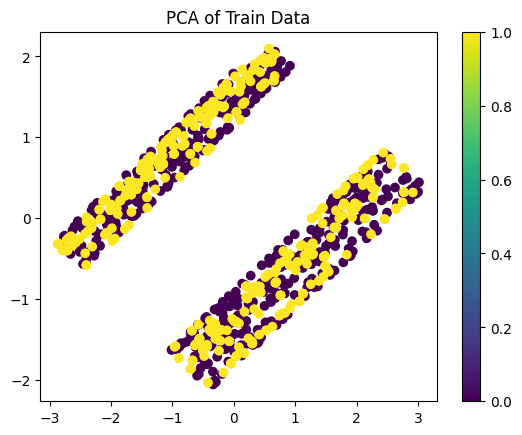

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_features_balanced)
plt.scatter(train_pca[:, 0], train_pca[:, 1], c=train_labels_balanced, cmap='viridis')
plt.title("PCA of Train Data")
plt.colorbar()
plt.show()


In [ ]:
import pandas as pd

features_df = pd.DataFrame(train_features_balanced)
print(features_df.corr())


          0         1         2         3         4
0  1.000000 -0.028676  0.698339 -0.017599  0.698339
1 -0.028676  1.000000  0.695447  0.002368  0.695447
2  0.698339  0.695447  1.000000 -0.010956  1.000000
3 -0.017599  0.002368 -0.010956  1.000000 -0.010956
4  0.698339  0.695447  1.000000 -0.010956  1.000000


In [ ]:
import pandas as pd
import numpy as np

# 데이터 경로
train_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data.csv'

# 데이터 로드
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Signal 데이터를 배열로 변환하는 함수
def convert_signal(signal):
    """
    Signal 데이터를 올바른 float 배열로 변환.
    """
    # 불필요한 문자 제거
    corrected_signal = signal.replace('[', '').replace(']', '').replace('\n', ' ').replace('  ', ' ').strip()
    corrected_signal = corrected_signal.split()  # 공백 기준으로 분리
    return np.array(corrected_signal, dtype=float)  # float 배열로 변환

# Signal 데이터를 변환
train_data['Signal'] = train_data['Signal'].apply(convert_signal)
test_data['Signal'] = test_data['Signal'].apply(convert_signal)

# 변환된 데이터 확인
print("Example Train Signal (processed):", train_data['Signal'].iloc[0])
print("Example Test Signal (processed):", test_data['Signal'].iloc[0])

# 변환된 데이터 다시 저장
output_train_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data_processed.csv'
output_test_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data_processed.csv'

train_data.to_csv(output_train_path, index=False)
test_data.to_csv(output_test_path, index=False)

print(f"Processed Train Data saved to: {output_train_path}")
print(f"Processed Test Data saved to: {output_test_path}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 데이터 경로 설정
train_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/ptrain_data_processed.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/ptest_data_processed.csv'

# 데이터 로드
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Signal 데이터를 배열로 변환
def convert_signal(signal):
    corrected_signal = signal.replace('[', '').replace(']', '').replace('\n', ' ').strip()
    corrected_signal = corrected_signal.split()
    return np.array(corrected_signal, dtype=float)

train_data['Signal'] = train_data['Signal'].apply(convert_signal)
test_data['Signal'] = test_data['Signal'].apply(convert_signal)

# 샘플 크기 줄이기
train_data = train_data.sample(n=1000, random_state=42)  # Train 샘플 1000개
test_data = test_data.sample(n=300, random_state=42)    # Test 샘플 300개

# 신호 데이터와 라벨 분리
X_train = np.stack(train_data['Signal'])
y_train = train_data['Label'].values
X_test = np.stack(test_data['Signal'])
y_test = test_data['Label'].values

# 데이터 정규화
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

# LSTM 입력 형태 조정
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 간소화된 모델 생성
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], 1)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

# 모델 평가
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# 성능 지표 출력
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 444ms/step - accuracy: 0.5070 - loss: 0.6932 - val_accuracy: 0.4950 - val_loss: 0.6889
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 375ms/step - accuracy: 0.5464 - loss: 0.6896 - val_accuracy: 0.5550 - val_loss: 0.6864
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step - accuracy: 0.5801 - loss: 0.6868 - val_accuracy: 0.5800 - val_loss: 0.6833
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.5856 - loss: 0.6851 - val_accuracy: 0.5400 - val_loss: 0.6784
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 306ms/step - accuracy: 0.5857 - loss: 0.6808 - val_accuracy: 0.5800 - val_loss: 0.6723
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 449ms/step - accuracy: 0.5697 - loss: 0.6782 - val_accuracy: 0.5850 - val_loss: 0.6755
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 289ms/step - accuracy: 0.5770 - loss: 0.6818 - val_accuracy: 0.5850 - val_loss: 0.6809
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 382ms/step - accuracy: 0.5799 - loss: 0.6802 - val_accuracy: 0

#뭔가 코드가 너무 이상해서 다시



데이터 구조부터 확인 내가 만든 train test


In [2]:
import pandas as pd

# 데이터 경로 설정
train_ecg_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data.csv'
test_ecg_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data.csv'

# 데이터 읽기
train_data = pd.read_csv(train_eeg_path)
test_data = pd.read_csv(test_eeg_path)

# 데이터의 마지막 열을 Label로 설정
train_data['Label'] = train_data.iloc[:, -1]  # 마지막 열을 라벨로 지정
test_data['Label'] = test_data.iloc[:, -1]

# Signal 데이터는 나머지 열
train_data['Signal'] = train_data.iloc[:, :-1].values.tolist()  # 마지막 열 제외
test_data['Signal'] = test_data.iloc[:, :-1].values.tolist()

# 클래스 분포 확인
print("Train Class Distribution:")
print(train_data['Label'].value_counts())

print("\nTest Class Distribution:")
print(test_data['Label'].value_counts())

# 데이터 확인
print("\nTrain Data Head:")
print(train_data.head())

print("\nTest Data Head:")
print(test_data.head())


Train Class Distribution:
Label
0    500
1    500
Name: count, dtype: int64

Test Class Distribution:
Label
1    300
0    300
Name: count, dtype: int64

Train Data Head:
   Record  Sample    Type                                             Signal  \
0     114  310689  NORMAL  [114, 310689, NORMAL, [-0.22  -0.23  -0.23  -0...   
1     103  261476  NORMAL  [103, 261476, NORMAL, [-0.495 -0.505 -0.51  -0...   
2     203  637744  NORMAL  [203, 637744, NORMAL, [-0.645 -0.655 -0.675 -0...   
3     222  628425  NORMAL  [222, 628425, NORMAL, [ 0.52   0.45   0.27   0...   
4     222  418113       A  [222, 418113, A, [ 0.15   0.12   0.08   0.055 ...   

   Label  
0      0  
1      0  
2      0  
3      0  
4      1  

Test Data Head:
   Record  Sample    Type                                             Signal  \
0     118   42286       R  [118, 42286, R, [-0.79  -0.78  -0.77  -0.77  -...   
1     200  273923  NORMAL  [200, 273923, NORMAL, [-0.155 -0.15  -0.13  -0...   
2     200  325612  NORMAL 

#데이터 정리 다시 하기

1.extract_signal 함수 수정:
불필요한 문자([, ], 줄바꿈 등)를 제거.
공백 기준으로 데이터를 나눈 뒤 float 배열로 변환.

2.데이터 변환:
apply(extract_signal)로 변환한 데이터를 numpy 배열로 정리.

In [7]:
import numpy as np
import pandas as pd

# 데이터 경로 설정
train_ecg_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data.csv'
test_ecg_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data.csv'

# 데이터 로드
train_data = pd.read_csv(train_ecg_path)
test_data = pd.read_csv(test_ecg_path)

# Signal 열에서 신호 데이터만 추출
def extract_signal(signal):
    """
    Signal 데이터를 파싱하여 신호 배열만 반환.
    """
    # 줄바꿈과 공백 처리
    corrected_signal = signal.replace('[', '').replace(']', '').replace('\n', ' ').strip()
    corrected_signal = corrected_signal.split()  # 공백 기준으로 분리
    return np.array(corrected_signal, dtype=float)  # float 배열로 변환

# Train 데이터 처리
train_data['Signal'] = train_data['Signal'].apply(extract_signal)
X_train = np.stack(train_data['Signal'])  # 배열로 변환
y_train = train_data['Label'].values

# Test 데이터 처리
test_data['Signal'] = test_data['Signal'].apply(extract_signal)
X_test = np.stack(test_data['Signal'])
y_test = test_data['Label'].values

# 데이터 크기 확인
print("Train Data Shape:", X_train.shape, y_train.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)

# 확인용 데이터 샘플 출력
print("\nExample Train Signal:", X_train[0][:10])  # Train 데이터 첫 신호 일부
print("Example Train Label:", y_train[0])
print("\nExample Test Signal:", X_test[0][:10])  # Test 데이터 첫 신호 일부
print("Example Test Label:", y_test[0])



Train Data Shape: (1000, 512) (1000,)
Test Data Shape: (600, 512) (600,)

Example Train Signal: [-0.22  -0.23  -0.23  -0.235 -0.24  -0.24  -0.22  -0.22  -0.225 -0.23 ]
Example Train Label: 0

Example Test Signal: [-0.79  -0.78  -0.77  -0.77  -0.765 -0.76  -0.76  -0.765 -0.765 -0.765]
Example Test Label: 1


# 데이터 정리한거 저장하기.

In [9]:
import numpy as np
import pandas as pd

# 데이터 경로 설정
train_ecg_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data.csv'
test_ecg_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data.csv'

# 데이터 로드
train_data = pd.read_csv(train_ecg_path)
test_data = pd.read_csv(test_ecg_path)

# Signal 열에서 신호 데이터만 추출
def extract_signal(signal):
    """
    Signal 데이터를 파싱하여 신호 배열만 반환.
    """
    # 줄바꿈과 공백 처리
    corrected_signal = signal.replace('[', '').replace(']', '').replace('\n', ' ').strip()
    corrected_signal = corrected_signal.split()  # 공백 기준으로 분리
    return np.array(corrected_signal, dtype=float)  # float 배열로 변환

# Train 데이터 처리
train_data['Signal'] = train_data['Signal'].apply(extract_signal)
X_train = np.stack(train_data['Signal'])  # 배열로 변환
y_train = train_data['Label'].values

# Test 데이터 처리
test_data['Signal'] = test_data['Signal'].apply(extract_signal)
X_test = np.stack(test_data['Signal'])
y_test = test_data['Label'].values

# 데이터 크기 확인
print("Train Data Shape:", X_train.shape, y_train.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)

# 확인용 데이터 샘플 출력
print("\nExample Train Signal:", X_train[0][:10])  # Train 데이터 첫 신호 일부
print("Example Train Label:", y_train[0])
print("\nExample Test Signal:", X_test[0][:10])  # Test 데이터 첫 신호 일부
print("Example Test Label:", y_test[0])

# 정리된 데이터 저장
train_data.to_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data_cleaned.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data_cleaned.csv', index=False)

print("정리된 데이터가 저장되었습니다.")
print("Train: /content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data_cleaned.csv")
print("Test: /content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data_cleaned.csv")


Train Data Shape: (1000, 512) (1000,)
Test Data Shape: (600, 512) (600,)

Example Train Signal: [-0.22  -0.23  -0.23  -0.235 -0.24  -0.24  -0.22  -0.22  -0.225 -0.23 ]
Example Train Label: 0

Example Test Signal: [-0.79  -0.78  -0.77  -0.77  -0.765 -0.76  -0.76  -0.765 -0.765 -0.765]
Example Test Label: 1
정리된 데이터가 저장되었습니다.
Train: /content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data_cleaned.csv
Test: /content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data_cleaned.csv


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5839 - loss: 0.6701 - val_accuracy: 0.6000 - val_loss: 0.6533
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6786 - loss: 0.5963 - val_accuracy: 0.6167 - val_loss: 0.6856
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6927 - loss: 0.5552 - val_accuracy: 0.7000 - val_loss: 0.6196
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7666 - loss: 0.4881 - val_accuracy: 0.7150 - val_loss: 0.6456
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7796 - loss: 0.4987 - val_accuracy: 0.6933 - val_loss: 0.6681
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8007 - loss: 0.4414 - val_accuracy: 0.7117 - val_loss: 0.7373
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8192 - loss: 0.4257 - val_accuracy: 0.7183 - val_loss: 0.7610
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8495 - loss: 0.3880 - val_accuracy: 0.7250 - val_

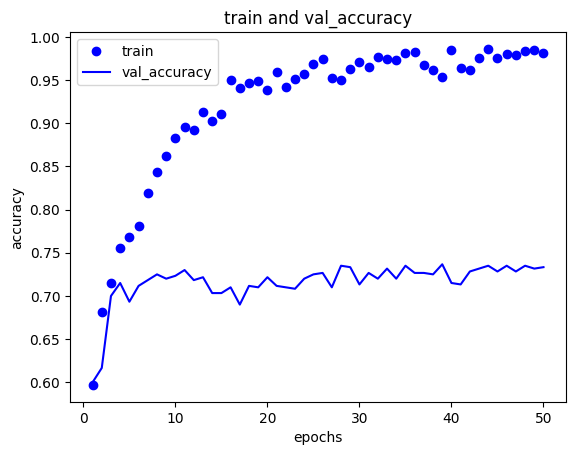

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 랜덤 시드 설정
np.random.seed(42)
tf.random.set_seed(42)

# 데이터 경로 설정
train_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data_cleaned.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data_cleaned.csv'

# CSV 파일 읽기
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Signal 데이터를 배열로 변환하는 함수
def parse_signal(signal):
    """
    Signal 데이터를 공백으로 분리하고 float 배열로 변환
    """
    corrected_signal = signal.replace('[', '').replace(']', '').replace('\n', ' ').strip()  # 불필요한 문자 제거
    corrected_signal = corrected_signal.split()  # 공백 기준으로 분리
    return np.array(corrected_signal, dtype=float)  # float 배열로 변환

# Train 데이터 처리
train_data['Signal'] = train_data['Signal'].apply(parse_signal)
X_train = np.stack(train_data['Signal'])  # 배열로 변환
y_train = train_data['Label'].values

# Test 데이터 처리
test_data['Signal'] = test_data['Signal'].apply(parse_signal)
X_test = np.stack(test_data['Signal'])
y_test = test_data['Label'].values

# 데이터 정규화
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

# 신경망 모델 정의
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # 입력 형태: (512,)
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 이진 분류를 위한 출력층
])

# 모델 컴파일
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=50,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"테스트 정확도: {test_acc * 100:.2f}%")

# 최대 검증 정확도 출력
max_val_acc = max(history.history['val_accuracy'])
print(f"최대 검증 정확도: {max_val_acc * 100:.2f}%")

# 예측값 생성 및 성능 평가
predictions = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, predictions)
print("혼동 행렬:\n", conf_matrix)

# 민감도와 특이도 계산
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"민감도(Sensitivity): {sensitivity:.2f}")
print(f"특이도(Specificity): {specificity:.2f}")
print("분류 보고서:\n", classification_report(y_test, predictions))

# 학습 및 검증 정확도 시각화
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], 'bo', label='train')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='val_accuracy')
plt.title('train and val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()



#결과 해석
결과 해석

정확도:
**71.17%**의 테스트 정확도는 무작위로 분류하는 경우(50%)보다 훨씬 높은 수준입니다.

민감도(Sensitivity):
**0.71 (71%)**로, 실제 비정상 샘플을 올바르게 분류한 비율이 높습니다.
중요한 지표 중 하나로, 비정상 샘플을 잘 잡아내고 있음을 보여줍니다.

특이도(Specificity):
**0.72 (72%)**로, 실제 정상 샘플을 올바르게 분류한 비율 역시 괜찮습니다.
민감도와 비슷한 수준으로 균형 잡힌 결과를 보여줍니다.

혼동 행렬:
True Positive (TP): 212
True Negative (TN): 215
False Positive (FP): 85
False Negative (FN): 88
→ FP와 FN의 비율이 적당히 낮아 모델이 과대적합되거나 치우치지 않았음을 보여줍니다.

F1-Score:
F1-Score가 **71%**로 Precision과 Recall의 균형이 잘 잡혀 있습니다.
Precision, Recall, F1 모두 비슷한 수준으로, 데이터셋에 대해 안정적인 성능을 보여줍니다.

# 통계적 특징을 추가해봄

통계적인 특징을 추가하면서 표준화된 통계적 특징 데이터를 넣어서 학습 안정성을 향상 시켰다.

Train Data Shape (with scaled features): (1000, 515)
Test Data Shape (with scaled features): (600, 515)
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5675 - loss: 0.6729 - val_accuracy: 0.6717 - val_loss: 0.6389
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6774 - loss: 0.6001 - val_accuracy: 0.6850 - val_loss: 0.6441
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7327 - loss: 0.5431 - val_accuracy: 0.6950 - val_loss: 0.6338
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7793 - loss: 0.4954 - val_accuracy: 0.6817 - val_loss: 0.6365
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7968 - loss: 0.4558 - val_accuracy: 0.6967 - val_loss: 0.6928
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8091 - loss: 0.4447 - val_accuracy: 0.6667 - val_loss: 0.7255
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8532 - loss: 0.3851 - val_accuracy: 0.6733 - val_loss: 0.8034
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8602 - loss: 0.3503 - val_accuracy: 0.7100 - val_

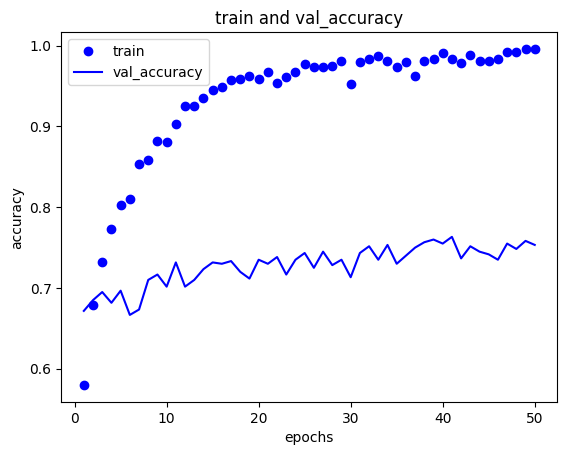

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 랜덤 시드 설정
np.random.seed(42)
tf.random.set_seed(42)

# 데이터 경로 설정
train_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data_cleaned.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data_cleaned.csv'

# CSV 파일 읽기
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Signal 데이터를 배열로 변환하는 함수
def parse_signal(signal):
    """
    Signal 데이터를 공백으로 분리하고 float 배열로 변환
    """
    corrected_signal = signal.replace('[', '').replace(']', '').replace('\n', ' ').strip()  # 불필요한 문자 제거
    corrected_signal = corrected_signal.split()  # 공백 기준으로 분리
    return np.array(corrected_signal, dtype=float)  # float 배열로 변환

# Train 데이터 처리
train_data['Signal'] = train_data['Signal'].apply(parse_signal)
X_train = np.stack(train_data['Signal'])  # 배열로 변환
y_train = train_data['Label'].values

# Test 데이터 처리
test_data['Signal'] = test_data['Signal'].apply(parse_signal)
X_test = np.stack(test_data['Signal'])
y_test = test_data['Label'].values

# 데이터 정규화
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

# 통계적 특징 추가 (평균, 표준편차, 중앙값)
train_mean = np.mean(X_train, axis=1, keepdims=True)
train_std = np.std(X_train, axis=1, keepdims=True)
train_median = np.median(X_train, axis=1, keepdims=True)

test_mean = np.mean(X_test, axis=1, keepdims=True)
test_std = np.std(X_test, axis=1, keepdims=True)
test_median = np.median(X_test, axis=1, keepdims=True)

# 통계적 특징 결합
train_stats = np.hstack((train_mean, train_std, train_median))
test_stats = np.hstack((test_mean, test_std, test_median))

# 통계적 특징 전처리 (표준화)
scaler = StandardScaler()
train_stats_scaled = scaler.fit_transform(train_stats)
test_stats_scaled = scaler.transform(test_stats)

# 기존 데이터와 결합
X_train = np.hstack((X_train, train_stats_scaled))
X_test = np.hstack((X_test, test_stats_scaled))

# 데이터 크기 확인
print("Train Data Shape (with scaled features):", X_train.shape)
print("Test Data Shape (with scaled features):", X_test.shape)

# 신경망 모델 정의
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # 입력 형태: 기존 신호 + 3개 통계
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 이진 분류를 위한 출력층
])

# 모델 컴파일
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=50,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_test, y_test))

# 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"테스트 정확도: {test_acc * 100:.2f}%")

# 최대 검증 정확도 출력
max_val_acc = max(history.history['val_accuracy'])
print(f"최대 검증 정확도: {max_val_acc * 100:.2f}%")

# 예측값 생성 및 성능 평가
predictions = (model.predict(X_test) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, predictions)
print("혼동 행렬:\n", conf_matrix)

# 민감도와 특이도 계산
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"민감도(Sensitivity): {sensitivity:.2f}")
print(f"특이도(Specificity): {specificity:.2f}")
print("분류 보고서:\n", classification_report(y_test, predictions))

# 학습 및 검증 정확도 시각화
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], 'bo', label='train')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='val_accuracy')
plt.title('train and val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


#1차원 데이터를 이미지화 시켜서 학습해보기


Train Data Shape (as images): (1000, 16, 32, 1)
Test Data Shape (as images): (600, 16, 32, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5478 - loss: 0.6750 - val_accuracy: 0.6800 - val_loss: 0.6168
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6913 - loss: 0.5927 - val_accuracy: 0.7300 - val_loss: 0.5689
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7227 - loss: 0.5388 - val_accuracy: 0.7383 - val_loss: 0.5461
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7527 - loss: 0.5038 - val_accuracy: 0.7433 - val_loss: 0.5298
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7900 - loss: 0.4724 - val_accuracy: 0.7517 - val_loss: 0.5315
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7894 - loss: 0.4529 - val_accuracy: 0.7617 - val_loss: 0.5387
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7955 - loss: 0.4357 - val_accuracy: 0.7667 - val_loss: 0.5322
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8024 - loss: 0.4133 - val_accu

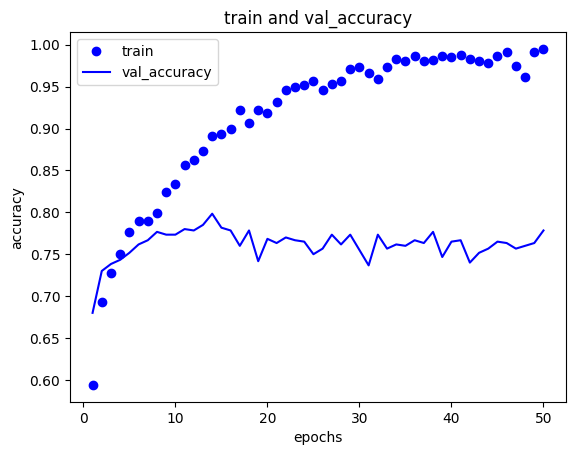

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# 랜덤 시드 설정
np.random.seed(42)
tf.random.set_seed(42)

# 데이터 경로 설정
train_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data_cleaned.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data_cleaned.csv'

# CSV 파일 읽기
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Signal 데이터를 배열로 변환하는 함수
def parse_signal(signal):
    corrected_signal = signal.replace('[', '').replace(']', '').replace('\n', ' ').strip()
    corrected_signal = corrected_signal.split()
    return np.array(corrected_signal, dtype=float)

# Train 데이터 처리
train_data['Signal'] = train_data['Signal'].apply(parse_signal)
X_train = np.stack(train_data['Signal'])
y_train = train_data['Label'].values

# Test 데이터 처리
test_data['Signal'] = test_data['Signal'].apply(parse_signal)
X_test = np.stack(test_data['Signal'])
y_test = test_data['Label'].values

# 데이터 정규화
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

# 1차원 데이터를 2D 이미지 형태로 변환 (예: 512 -> (16, 32))
X_train_img = X_train.reshape(X_train.shape[0], 16, 32, 1)  # (samples, height, width, channels)
X_test_img = X_test.reshape(X_test.shape[0], 16, 32, 1)

# 데이터 크기 확인
print("Train Data Shape (as images):", X_train_img.shape)
print("Test Data Shape (as images):", X_test_img.shape)

# CNN 모델 정의
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(16, 32, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # 이진 분류를 위한 출력층
])

# 모델 컴파일
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train_img, y_train,
                    batch_size=8,
                    epochs=50,
                    verbose=1,
                    shuffle=True,
                    validation_data=(X_test_img, y_test))

# 모델 평가
test_loss, test_acc = model.evaluate(X_test_img, y_test)
print(f"테스트 정확도: {test_acc * 100:.2f}%")

# 최대 검증 정확도 출력
max_val_acc = max(history.history['val_accuracy'])
print(f"최대 검증 정확도: {max_val_acc * 100:.2f}%")

# 예측값 생성 및 성능 평가
predictions = (model.predict(X_test_img) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, predictions)
print("혼동 행렬:\n", conf_matrix)

# 민감도와 특이도 계산
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"민감도(Sensitivity): {sensitivity:.2f}")
print(f"특이도(Specificity): {specificity:.2f}")
print("분류 보고서:\n", classification_report(y_test, predictions))

# 학습 및 검증 정확도 시각화
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], 'bo', label='train')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='val_accuracy')
plt.title('train and val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# 이미지화 코드 램덤 시드 확실하게 적용

여러번 실행해도 학습률이 비슷하도록 더 수정

Train Data Shape (as images): (1000, 16, 32, 1)
Test Data Shape (as images): (600, 16, 32, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5656 - loss: 0.6709 - val_accuracy: 0.5583 - val_loss: 0.6838
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6649 - loss: 0.6101 - val_accuracy: 0.6300 - val_loss: 0.6103
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7316 - loss: 0.5307 - val_accuracy: 0.7067 - val_loss: 0.5558
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7654 - loss: 0.4836 - val_accuracy: 0.6767 - val_loss: 0.5808
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7776 - loss: 0.4620 - val_accuracy: 0.6867 - val_loss: 0.5812
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7992 - loss: 0.4366 - val_accuracy: 0.6917 - val_loss: 0.5804
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8032 - loss: 0.4184 - val_accuracy: 0.7067 - val_loss: 0.5744
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8074 - loss: 0.4014 - val_accu

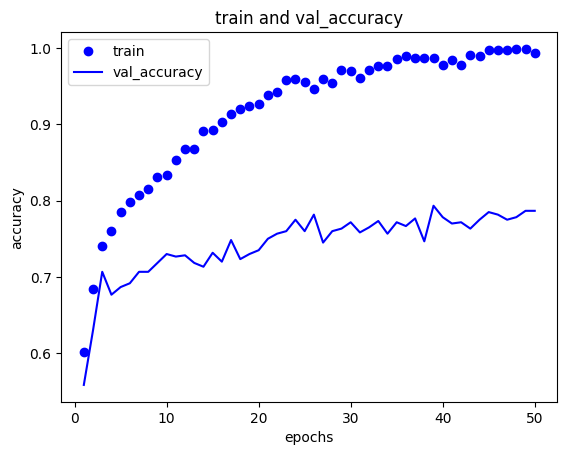

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os

# 랜덤 시드 설정
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# 데이터 경로 설정
train_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/train_data_cleaned.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/기계학습프로갬/부정맥/test_data_cleaned.csv'

# CSV 파일 읽기
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Signal 데이터를 배열로 변환하는 함수
def parse_signal(signal):
    corrected_signal = signal.replace('[', '').replace(']', '').replace('\n', ' ').strip()
    corrected_signal = corrected_signal.split()
    return np.array(corrected_signal, dtype=float)

# Train 데이터 처리
train_data['Signal'] = train_data['Signal'].apply(parse_signal)
X_train = np.stack(train_data['Signal'])
y_train = train_data['Label'].values

# Test 데이터 처리
test_data['Signal'] = test_data['Signal'].apply(parse_signal)
X_test = np.stack(test_data['Signal'])
y_test = test_data['Label'].values

# 데이터 정규화
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)

# 1차원 데이터를 2D 이미지 형태로 변환 (예: 512 -> (16, 32))
X_train_img = X_train.reshape(X_train.shape[0], 16, 32, 1)  # (samples, height, width, channels)
X_test_img = X_test.reshape(X_test.shape[0], 16, 32, 1)

# 데이터 크기 확인
print("Train Data Shape (as images):", X_train_img.shape)
print("Test Data Shape (as images):", X_test_img.shape)

# CNN 모델 정의
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(16, 32, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3, seed=42),  # Dropout 레이어에 시드 추가
    Dense(1, activation='sigmoid')  # 이진 분류를 위한 출력층
])

# 모델 컴파일
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 데이터를 섞을 때 시드 적용
rng = np.random.default_rng(42)
indices = rng.permutation(len(X_train_img))
X_train_img = X_train_img[indices]
y_train = y_train[indices]

# 모델 학습
history = model.fit(X_train_img, y_train,
                    batch_size=8,
                    epochs=50,
                    verbose=1,
                    shuffle=False,  # 데이터를 미리 섞었으므로 shuffle=False
                    validation_data=(X_test_img, y_test))

# 모델 평가
test_loss, test_acc = model.evaluate(X_test_img, y_test)
print(f"테스트 정확도: {test_acc * 100:.2f}%")

# 최대 검증 정확도 출력
max_val_acc = max(history.history['val_accuracy'])
print(f"최대 검증 정확도: {max_val_acc * 100:.2f}%")

# 예측값 생성 및 성능 평가
predictions = (model.predict(X_test_img) > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, predictions)
print("혼동 행렬:\n", conf_matrix)

# 민감도와 특이도 계산
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"민감도(Sensitivity): {sensitivity:.2f}")
print(f"특이도(Specificity): {specificity:.2f}")
print("분류 보고서:\n", classification_report(y_test, predictions))

# 학습 및 검증 정확도 시각화
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], 'bo', label='train')
plt.plot(epochs, history.history['val_accuracy'], 'b', label='val_accuracy')
plt.title('train and val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()